# Data exploration notebook

A simple notebook just to look at the data we got and start to experiment around.

In [1]:
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from src.scoring import rps
from src.strategy import get_weight_from_predictions

In [3]:
RELOAD = False
START_TEST = "2019-01-01"

In [4]:
#assets = pd.read_csv("../data/assets_m6.csv")
universe = pd.read_csv("../data/M6_Universe.csv", index_col=0)
universe = universe[universe.symbol != "IEFM.L"].copy() #  has data issues

In [5]:
def get_company_name(ticker_symbol, universe=universe):
    return universe[universe.symbol==ticker_symbol].name.iloc[0]

In [6]:
universe.head()

,class,symbol,name,GICS_sector/ETF_type,GICS_industry/ETF_subtype
id,,,,,
1,Stock,ABBV,AbbVie,Health Care,Pharmaceuticals
2,Stock,ACN,Accenture,Information Technology,IT Consulting & Other Services
3,Stock,AEP,American Electric Power,Utilities,Electric Utilities
4,Stock,AIZ,Assurant,Financials,Multi-line Insurance
5,Stock,ALLE,Allegion,Industrials,Building Products


In [7]:
universe.groupby("class")["name"].count()

class
ETF      49
Stock    50
Name: name, dtype: int64

In [8]:
universe.groupby(["class", "GICS_sector/ETF_type"])["name"].count()

class  GICS_sector/ETF_type  
ETF    Commodities                3
       Equities                  36
       Fixed Income               9
       Volatility                 1
Stock  Communication Services     3
       Consumer Discretionary     6
       Consumer Staples           3
       Energy                     2
       Financials                 7
       Health Care                6
       Industrials                7
       Information Technology     7
       Materials                  3
       Real Estate                3
       Utilities                  3
Name: name, dtype: int64

In [9]:
universe.groupby(["class", "GICS_industry/ETF_subtype"])["name"].count()

class  GICS_industry/ETF_subtype            
ETF    Credit-Europe                             2
       Credit-US                                 2
       Diversified Commodity                     1
       Equity Style-Europe                       2
       Equity Style-North America                3
       Govt-Europe                               1
       Govt-Global                               1
       Govt-US                                   3
       Large Cap-Asia                            7
       Large Cap-Europe                          4
       Large Cap-Global                          1
       Large Cap-North America                   2
       Large Cap-South America                   1
       Precious Metals                           2
       Sector-Global                             4
       Sector-US                                10
       Small Cap-Europe                          1
       Small Cap-North America                   1
       US                            

In [10]:
if RELOAD:
    all_stocks_hist = pd.DataFrame()
    for iid in tqdm(universe.index):
        ticker = universe.loc[iid, "symbol"]
        stock = yf.Ticker(ticker)
        hist = stock.history(period="max")
        all_stocks_hist[ticker] = hist.stack()
    all_stocks_hist.to_pickle("../data/stocks_hist.pkl")
else:
    all_stocks_hist = pd.read_pickle("../data/stocks_hist.pkl")

20


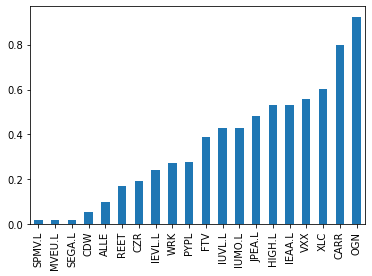

In [11]:
nan_fraction = all_stocks_hist.isna().mean().sort_values()
(nan_fraction[nan_fraction > 0]).plot.bar()
print(nan_fraction[nan_fraction > 0].shape[0])

In [12]:
closing_prices = all_stocks_hist.unstack(-1).swaplevel(axis=1)["Close"].bfill()  # backfilling price

<AxesSubplot:xlabel='Date'>

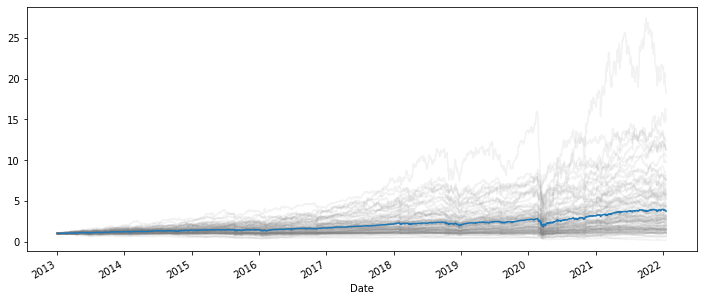

In [13]:
(closing_prices / closing_prices.iloc[0]).plot(legend=False, color="gray", alpha=0.1, figsize=(12, 5))
(closing_prices / closing_prices.iloc[0]).mean(axis=1).plot()

In [14]:
price_corr = closing_prices.corr()

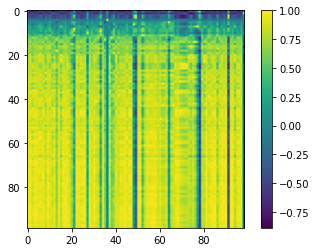

In [15]:
plt.imshow(price_corr.sort_values(price_corr.columns[0]))
plt.colorbar()

In [16]:
daily_returns = np.log(1 + closing_prices.pct_change().dropna())

In [17]:
monthly_returns = daily_returns.resample("MS").sum()

In [18]:
monthly_quintiles = monthly_returns.apply(lambda x: (x.rank(ascending=True) // 20 +1).clip(upper=5)).astype(int)

In [19]:
monthly_quintiles.head()

,ABBV,ACN,AEP,AIZ,ALLE,AMAT,AMP,AMZN,AVB,AVY,...,XLF,XLV,XLE,XLY,XLI,XLC,XLU,XLP,XLB,VXX
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,5,4,4,5,3,5,3,4,1,5,...,4,5,5,4,4,3,4,5,3,4
2013-02-01,3,4,5,5,3,4,4,3,2,5,...,3,3,3,3,4,3,4,5,2,4
2013-03-01,5,3,4,5,3,2,5,3,4,5,...,5,5,4,5,4,3,5,5,4,4
2013-04-01,5,5,5,4,3,4,3,2,5,1,...,4,4,3,4,2,3,5,5,3,4
2013-05-01,1,3,1,4,3,4,5,4,2,4,...,5,3,4,4,5,3,1,1,4,4


In [20]:
test_set = monthly_quintiles.loc[START_TEST:].index
y_true = monthly_quintiles.loc[test_set]


In [21]:
prediction_random = pd.DataFrame(
    np.random.randint(1, 6, size=y_true.shape),
    index=y_true.index,
    columns=y_true.columns
)

In [22]:
y_true_class = pd.get_dummies(y_true.stack())
prediction_proba_random_1 = pd.get_dummies(prediction_random.stack())
prediction_proba_random_2 = pd.DataFrame(
    np.random.rand(*y_true_class.shape), 
    index=y_true_class.index,
    columns=y_true_class.columns
)
prediction_proba_random_2 = prediction_proba_random_2.div(prediction_proba_random_2.sum(axis=1), axis=0)
prediction_proba_equal = pd.DataFrame(
    0.2, 
    index=y_true_class.index,
    columns=y_true_class.columns
)

In [66]:
window_models = {}

for window in [12, 48]:
    df = pd.DataFrame({i: monthly_quintiles.shift(i+1).stack() for i in range(window)}).dropna()
    proba_window = df.stack().groupby(level=[0, 1]).value_counts().unstack(fill_value=0) / window
    proba_window = proba_window.loc[test_set]
    window_models[window] = proba_window

In [67]:
static = pd.get_dummies(monthly_quintiles.loc[:START_TEST].stack()).T.stack().mean(axis=1).unstack(0)
prediction_static = pd.DataFrame({d: static.stack() for d in test_set}).T.stack(0)
prediction_static.index.names = y_true_class.index.names

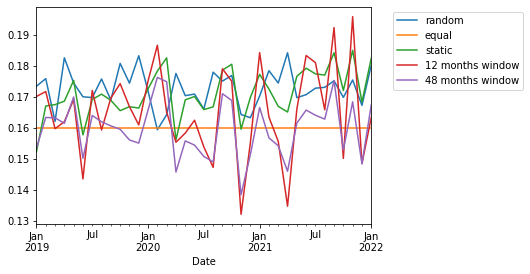

In [68]:
score_random_1 = rps(y_true_class, prediction_proba_random_1)
score_random_2 = rps(y_true_class, prediction_proba_random_2)
score_equal = rps(y_true_class, prediction_proba_equal)
score_static = rps(y_true_class, prediction_static)

ax = score_random_2.plot(label="random")
score_equal.plot(label="equal", ax=ax)
score_static.plot(label="static", ax=ax)

for w in window_models:
    score_window = rps(y_true_class, window_models[w])
    score_window.plot(label=f"{w} months window", ax=ax)

ax.legend(bbox_to_anchor=(1.05, 1))

In [69]:
score_window.mean()

0.15973667796584462

In [70]:
score_equal.mean()

0.16000000000000006

In [36]:
(score_equal.mean() - score_window.mean()) / score_equal.mean()

0.0016457627134714916

Using a 48 months window barely beats the equal probability prediction! Probably no statistically significant difference.

<AxesSubplot:xlabel='Date'>

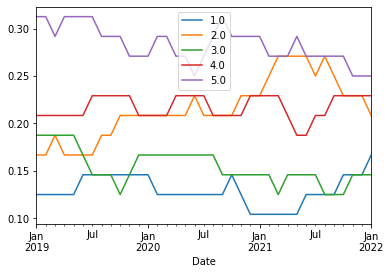

In [27]:
# an example
window_models[w].unstack(-1).swaplevel(axis=1)["AMZN"].plot()

Can we make a strategy out of this simple model?

In [28]:
best_prediction = window_models[48]

In [30]:
daily_test_index = closing_prices.loc[START_TEST:].index

In [31]:
market_returns = (1 + closing_prices.pct_change().loc[daily_test_index]).mean(axis=1)

In [32]:
portfolio_returns_k = pd.DataFrame()
for k in [1, 2, 3]:
    weights = get_weight_from_predictions(best_prediction, k)
    daily_weights = weights.resample("d").pad().reindex(daily_test_index).ffill()
    portfolio_returns_k[k] = (daily_weights * (1 + closing_prices.pct_change().loc[daily_test_index])).sum(axis=1)

In [33]:
portfolio_returns_k.prod()

1    1.544558
2    1.595515
3    1.606680
dtype: float64

In [34]:
market_returns.prod()

1.7530098116155741

<AxesSubplot:xlabel='Date'>

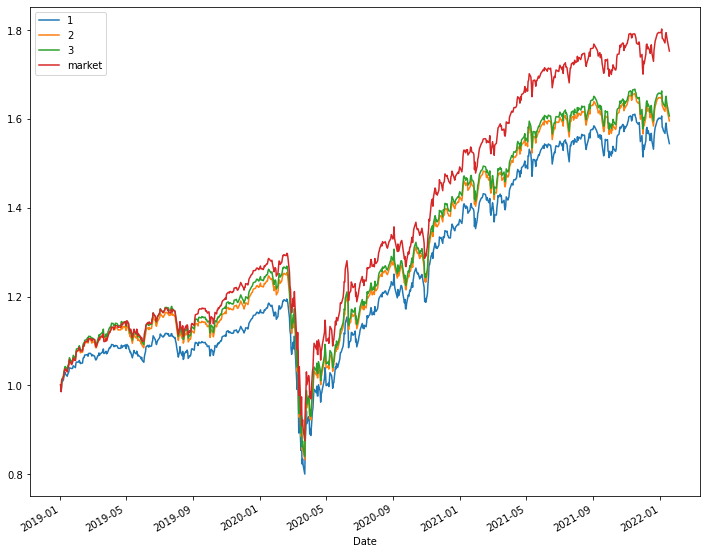

In [35]:
ax = portfolio_returns_k.cumprod().plot(figsize=(12, 10))
market_returns.to_frame("market").cumprod().plot(ax=ax)